# Run a quantum circuit in Cirq, with a Pasqal device as a backend
<br>
<br>
<div>
<img src="files/files/Cirq_pasqal.png" width="700"/>
</div>
<br>
<br>

In this notebook, we show how to program a quantum circuit for Pasqal using cirq. The first step is to import cirq, and Pasqal custom classes. We use ``PasqalVirtualDevice`` to showcase how Cirq enforces Pasqal's devices' restrictions throughout the process (note that unconstrained circuit generation is also supported through the ``PasqalDevice`` class).

In [1]:
import cirq
from cirq import ops
from cirq.pasqal import ThreeDQubit, TwoDQubit, PasqalVirtualDevice, PasqalNoiseModel

## Create an array of qubits on a lattice
<br>
<br>
The QPU of Pasqal is made of neutral atoms controlled by lasers. Individual atoms are trapped at well-defined positions in 1, 2 or even 3D, as shown on the following plot (Nature 561, 79 (2018)).
<br>
<br>


<div>
<img src="files/files/eiffel_tower.png" width="500"/>
</div>
<br>
<br>
We created a custom class in cirq, ThreeDGridQubit, that corresponds to a qubit placed on a 3D grid. Let us start by creating a register comprising $36=6\times6$ qubits in 2D, regularly arranged on a square lattice. It corresponds to the following configuration (image taken from Nature 561, 79 (2018))

<div>
<img src="files/files/grid_atoms.png" width="300"/>
</div>
<br>
<br>

In [2]:
width=6
height=6
depth=1
# Creating p_qubits, a list of ThreeDGridQubit.
p_qubits=[ThreeDQubit(row, col, lay) 
          for row in range(width) 
          for col in range(height)
          for lay in range(depth)]

## Create a PasqalDevice

Multi-qubit gates can be applied between qubits in the device, provided that the distance between them is smaller than the so-called Rydberg blocade radius (or control radius), that can be passed as a parameter of the device (in units of the lattice size). Here, we instantiate a ``PasqalVirtualDevice`` with 36 qubits and a control radius of $2.1$. 
<br>
<br>
Using the ``Circuit`` class of Cirq, one can then build a circuit that will be implemented with a ``PasqalVirtualDevice`` as a backend.
<br>

In [3]:
# Create a Pasqal device with a control radius of 2.1 (in units of the lattice spacing)
p_device=PasqalVirtualDevice(control_radius=2.1, qubits=p_qubits)

# Initialize a circuit, specifying the device
p_circuit = cirq.Circuit(device=p_device)

# Create the circuit
p_circuit.append(cirq.CZ(p_qubits[0], p_qubits[1]))
p_circuit.append(cirq.Z(p_qubits[0]))
p_circuit.append(cirq.CX(p_qubits[0], p_qubits[2]))

Notice how, by declaring the device at the beginning, all non-native gates are automatically decomposed and each moment forced to have a single gate.

In [4]:
print(p_circuit)

(0, 0, 0): ───@───Z───────────────────@──────────────────
              │                       │
(0, 1, 0): ───@───────────────────────┼──────────────────
                                      │
(0, 2, 0): ───────────PhX(-0.5)^0.5───@───PhX(0.5)^0.5───


When the distance between the two qubits involved in the gate is greater than the control radius, as shown for example in the following plot, cirq will raise an error.
<br>
<br>
<img src="files/files/r_radius.001.png" width="300"/><br>

In [5]:
# It is impossible to add a multi-qubit gate if the qubits involved are too far away
try:
    p_circuit.append(cirq.CZ(p_qubits[0], p_qubits[-1]))
except ValueError as msg:
    print("ERROR:", msg)
else:
    print("Failed to raise the expected ValueError.")

ERROR: Qubits pasqal.ThreeDQubit(0, 0, 0), pasqal.ThreeDQubit(5, 5, 0) are too far away


## Send a circuit to a remote Pasqal machine


Using the Circuit class of Cirq, one can then build a circuit that will be implemented with one of Pasqal's devices as a backend.


The real QPU is not plugged in yet as a backend. If you send us your circuit, we currently use a classical emulator as a backend to determine the result of your simulation. As emulating a quantum circuit with a large number of qubits is computationnaly intensive, here we choose to realize a circuit on a smaller register.

More precisely, we will implement Grover's algorithm to search for the state $|10\rangle$, which corresponds to the circuit:

<br>
<img src="files/files/Grover_circuit.png" width="750"/><br>
<br>

Bear in mind that this is a naïve implementation that can be substantially optimized, particularly in the oracle and the usage of an ancilla, but that is beyond the scope of this tutorial.

Here is the cirq implementation of the circuit using generators:

In [6]:
import numpy as np

#Place qubits at vertices of an equilateral triangle
qs = [TwoDQubit(0, 0), TwoDQubit(1, 0), TwoDQubit(0.5, np.sqrt(3)/2)]
q_meas = [TwoDQubit(1, 0), TwoDQubit(0, 0)]

def state_preparation():
    for q in qs[:-1]:
        yield cirq.H(q)
    yield cirq.X(qs[-1])
    yield cirq.H(qs[-1])

def oracle():
    # Signals the state 10
    yield cirq.X(qs[0])
    yield cirq.CCX(*qs)
    yield cirq.X(qs[0])

def grover_operator():
    for q in qs[:-1]:
        yield cirq.H(q)
        yield cirq.X(q)

    yield cirq.CZ(*qs[:-1])

    for q in qs[:-1]:
        yield cirq.X(q)
        yield cirq.H(q)
        
def generate_grover():
    yield state_preparation()
    yield oracle()
    yield grover_operator()
        
device = PasqalVirtualDevice(control_radius=1.1, qubits=qs)        
grover_circuit = cirq.Circuit(generate_grover(), device=device)
grover_circuit.append(cirq.measure(*q_meas, key='x'))

Now, to execute the circuit on one of our servers, one has to create a sampler that will send the circuit to the remote host address. One currently needs a token to do this. Please contact us to get one !

In [7]:
# To execute on one of Pasqal's servers, get an access token and uncomment these lines
# sampler = cirq.pasqal.PasqalSampler(remote_host='http://34.98.71.118/v0/pasqal',
#                                     access_token='')

Alternatively, small circuits can also be simullated locally using Cirq's `Simulator`, which we will do here. 

In [8]:
sampler = cirq.Simulator()

In [9]:
data_raw = sampler.run(grover_circuit, repetitions=200)

Next, we can plot the results obtained.

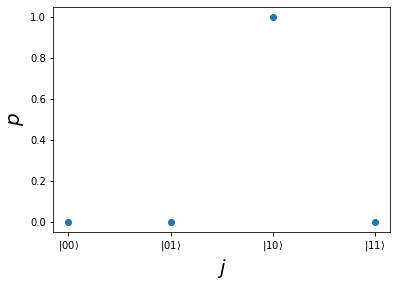

In [10]:
import matplotlib.pyplot as plt

data0 = data_raw.data.to_dict()
vec=[j for j in range(4)]
res=np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res=res/200.

fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res,'o')
ax.set_xticks(vec)
ax.set_xticklabels([r'$|00\rangle$',r'$|01\rangle$', r'$|10\rangle$', r'$|11\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

In this particular case, it takes a single Grover iteration to find the correct result ($|10\rangle$) with 100% probability on a perfect device.

## Incorporate the effect of noise during a classical emulation of the circuit
<br>
<br>
Current NISQ processors are imperfect and prone to errors. We incorporated in Cirq a typical noise model for Pasqal devices, that can be used when one emulates the behavior of the device with a classical computer.
<br>

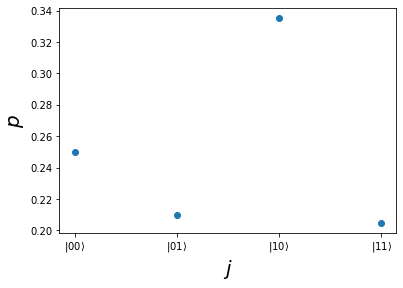

In [11]:
# Use the custom noise model of Pasqal devices
noise_model = PasqalNoiseModel(device)
grover_circuit = cirq.Circuit(generate_grover(), device=device)
grover_circuit = grover_circuit.with_noise(noise_model)
grover_circuit.append(cirq.measure(*q_meas, key='x'))

# Run a simulation locally locally
data_raw = sampler.run(grover_circuit, repetitions=200)

# Plot the results
data0 = data_raw.data.to_dict()
vec=[j for j in range(4)]
res=np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res=res/200.

fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res,'o')
ax.set_xticks(vec)
ax.set_xticklabels([r'$|00\rangle$',r'$|01\rangle$', r'$|10\rangle$', r'$|11\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

One still finds a rather large probability to measure $|10\rangle$, but we note the appearance of other measurement outcomes, due to the presence of noise.